In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [6]:
acc_eachcoordpair = np.zeros((n_subjects, n_rois, n_tasks, 2, 3))

un_coord = np.unique(grid_pts[:,0])

pairs_do = [un_coord[[0,1]], un_coord[[1,2]], un_coord[[2,3]]]

pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
  
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)

            coord_actual = pt_labs[:,ii].round(2)
            
            for pi in [0,1,2]:
                
                pair = pairs_do[pi]

                inds = np.isin(coord_actual, pair) & is_main_grid
                
                for ri in range(n_rois):
                    
                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    # predicted coordinate along axis of interest
                    coord_pred = grid_pts[pred][:,ii]
                    
                    # round the predictions to nearest value within the current pair of corods
                    pair_pred = np.zeros_like(coord_pred)
                    for uu in un_coord:
                        idx = coord_pred==uu
                        val = pair[np.argmin(np.abs(pair-uu))]
                        pair_pred[idx] = val
                        
                    acc = np.mean(coord_actual[inds]==pair_pred[inds])
                    
                    acc_eachcoordpair[si, ri, ti, ii, pi] = acc

In [7]:
within_pairs = np.mean(acc_eachcoordpair[:,:,:,:,[0,2]], axis=4)
across_pairs = acc_eachcoordpair[:,:,:,:,1]



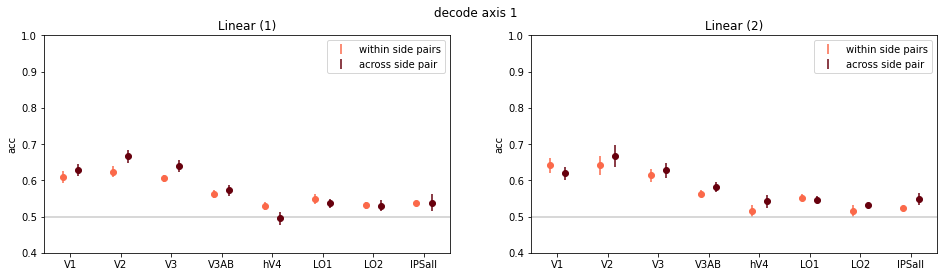

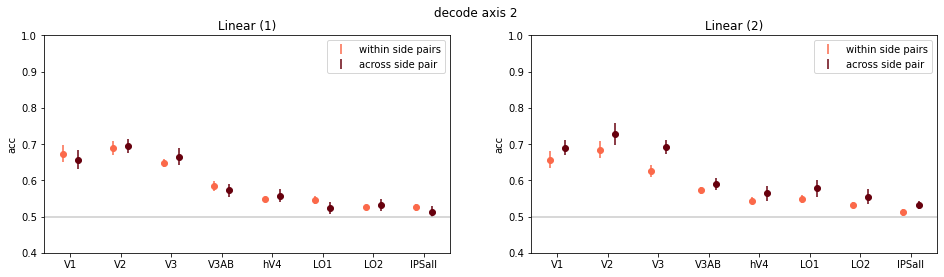

In [8]:
pair_colors = cm.Reds(np.linspace(0,1,5))[[2,4],:]
pair_names = ['within side pairs','across side pair']

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, [avals, pair_name] in enumerate(zip([within_pairs, across_pairs], \
                                                   pair_names)):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = avals[:,:,ti,ii]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


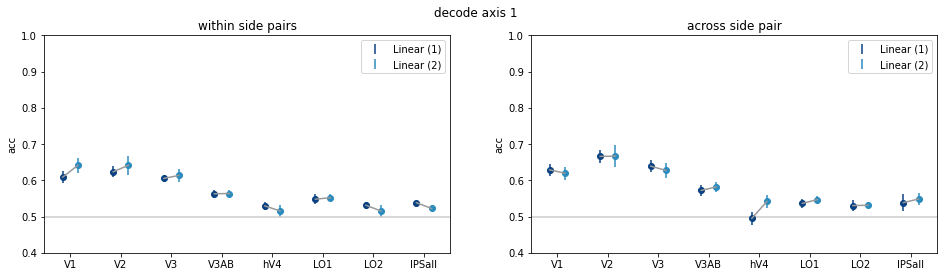

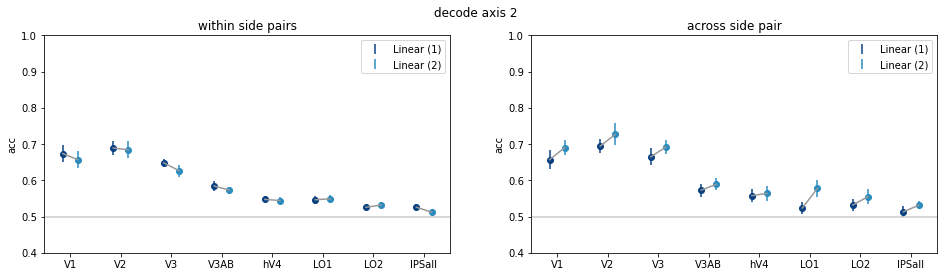

In [9]:
pair_names = ['within side pairs','across side pair']

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for pi, [avals, pair_name] in enumerate(zip([within_pairs, across_pairs], \
                                                   pair_names)):

        plt.subplot(1,2,pi+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for ti, task_name in enumerate(task_names[0:2]):

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
          
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,[0,1],ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,task_names[0:2])

        plt.title(pair_name)

    plt.suptitle('decode %s'%axis_name)


Text(0.5, 0.98, 'ratio of across-side accuracy to within-side accuracy')

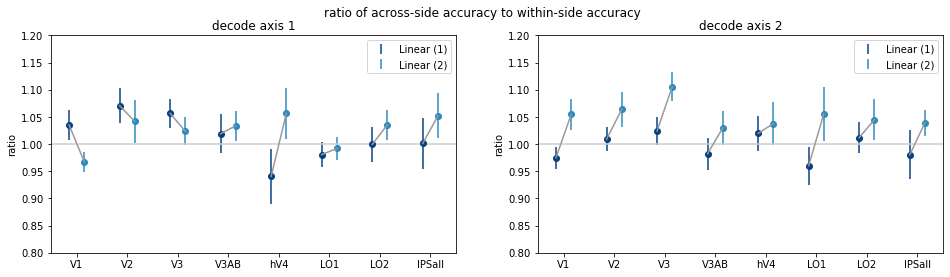

In [10]:
ratio = across_pairs/within_pairs

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

    
plt.figure(figsize=(16,4))

for ii, axis_name in enumerate(['axis 1','axis 2']):

    plt.subplot(1,2,ii+1)

    plt.axhline(1, color=[0.8, 0.8, 0.8])

    lh = []

    avals = ratio

    for ti, task_name in enumerate(task_names[0:2]):

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(avals[:,ri,[0,1],ii], axis=0)
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([0.8, 1.2])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('ratio')

    plt.legend(lh,task_names[0:2])

    plt.title('decode %s'%axis_name)

plt.suptitle('ratio of across-side accuracy to within-side accuracy')

Text(0.5, 0.98, 'ratio of across-side accuracy to within-side accuracy')

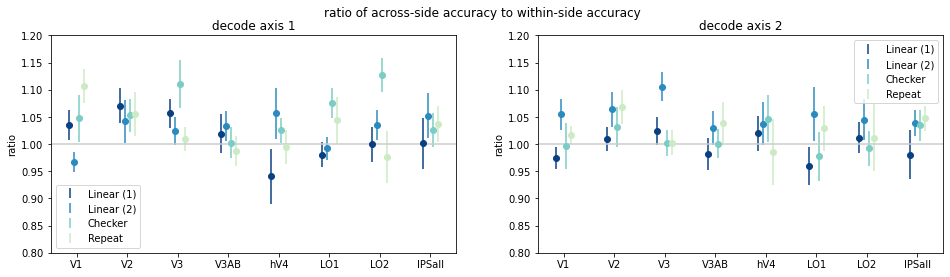

In [11]:
ratio = across_pairs/within_pairs

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 4)

    
plt.figure(figsize=(16,4))

for ii, axis_name in enumerate(['axis 1','axis 2']):

    plt.subplot(1,2,ii+1)

    plt.axhline(1, color=[0.8, 0.8, 0.8])

    lh = []

    avals = ratio

    for ti, task_name in enumerate(np.array(task_names)[ti_plot]):

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

   
    plt.ylim([0.8, 1.2])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('ratio')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s'%axis_name)

plt.suptitle('ratio of across-side accuracy to within-side accuracy')

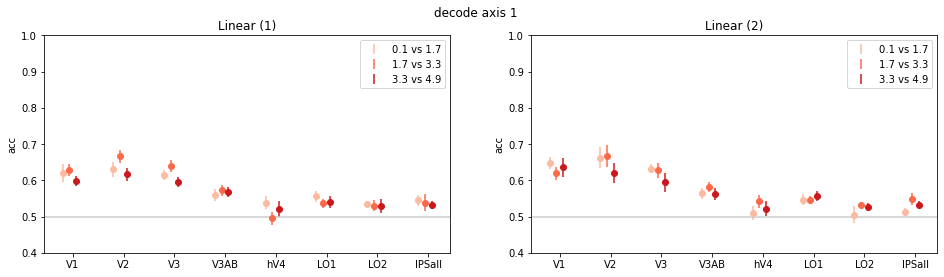

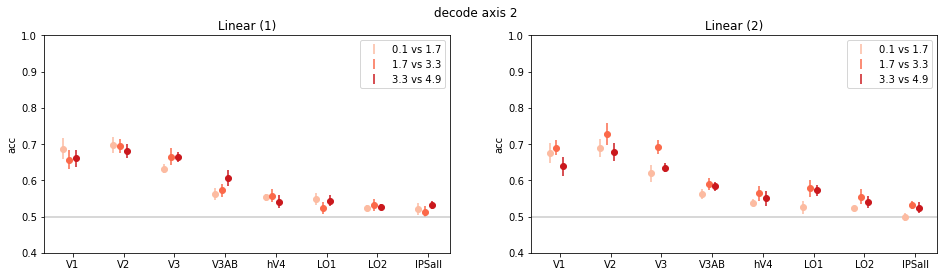

In [12]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, pair_name in enumerate(pair_names):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = acc_eachcoordpair[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)
